In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random
import scipy

First, I'll read in the data and the labels and print a random example from each of the two classes.

In [230]:
data = np.loadtxt('data.dat')
data = data.T
data.shape

(1990, 784)

In [231]:
true_labels = np.loadtxt('label.dat')
true_labels.shape

(1990,)

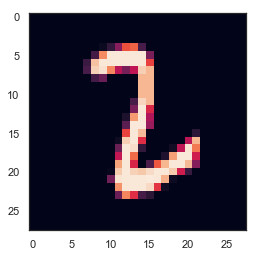

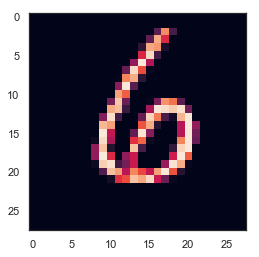

In [234]:
for j in [2.0,6.0]:    
    indices = [i for i, x in enumerate(list(true_labels)) if x == j]
    index = random.choice(indices)
    pic = data[index]
    new_pic = np.reshape(pic, [28,28], order='F')
    plt.imshow(new_pic)
    plt.show()

In [248]:
k = 2
m = data.shape[0]
p = data.shape[1]

Next, I'm going to define all of the functions that I use throughout the EM algorithm.

First, I define a function called pdf, which takes in the parameters of x, mu, and cov. This function returns the probability of $x$ given $\mu$ and $\sum$ for a Gaussian. The function takes the form of:

$$\mathcal{N}(X|\mu,\Sigma) =  \frac{1}{det(\Sigma)^{1/2}(2\pi)^{d/2}}exp(\frac{-1}{2}(x-\mu)^{T}\Sigma^{-1}(x-mu))$$

For computation sake, I removed the $(2\pi)^{d/2}$ from the bottom half of the first fraction.

In [249]:
def pdf(x, mu, cov):
    first = 1 / (np.linalg.det(cov)**(1/2))
    second = (-1/2) * ((x-mu).T@(np.linalg.inv(cov)))@((x-mu))
    return float(first * np.exp(second))

Next, I defined a function called loglikelihood, which finds the log likelihood for the EM. I use this function to check the log-likelihood after each iteration of EM to see if the algorithm is improving and/or converging. It looks like this:

$$\log (\pi_{1}\mathcal{N}(X_{1}|\mu_{1},\Sigma_{1})+\pi_{2}\mathcal{N}(X_{2}|\mu_{2},\Sigma_{2}))$$

In [250]:
def loglikelihood(x):
    return np.log(pi[0]*pdf(x, mus[0], covs[0])+pi[1]*pdf(x, mus[1], covs[1]))

Next, I define the E-step part of the EM algorithm. The E-step looks like:

$$\tau_{i}^{k}=\frac{\pi_{k}\mathcal{N}(X_{k}|\mu_{k},\Sigma_{1})}{\sum_{1}^{{k}'}\pi_{{k}'}\mathcal{N}(X_{{k}'}|\mu_{{k}'},\Sigma_{{k}'})}$$

To implement it in python, I loop through the data and calculate $\tau_{i}^{k}$ for each data point and assign it to the ith row and kth column of my variable tau.

In [251]:
def estep(pi):
    tau = np.zeros((m,2))
    vpdf = np.vectorize(pdf)
    for i in range(m):
        
        p1 = pi[0]*pdf(data[i], mus[0], covs[0])
        p2 = pi[1]*pdf(data[i], mus[1], covs[1])
        
        bottom = p1+p2
        tau[i,0] = p1/bottom
        tau[i,1] = p2/bottom
        
    return tau

Next, we update our paramenters in the M step. The updates are:

$$\pi_{k}=\frac{\sum_{1}^{i}\tau_{i}^{k}}{m}$$
$$\mu_{k}=\frac{\sum_{1}^{i}\tau_{i}^{k}x_{i}}{\sum_{1}^{i}\tau_{i}^{k}}$$
$$\Sigma_{k}=\frac{\sum_{1}^{i}\tau_{i}^{k}(x_{i}-\mu_{k})(x_{i}-\mu_{k})^{T}}{\sum_{1}^{i}\tau_{i}^{k}}$$

In [252]:
def mstep(tau,mus):
    # update pi
    sums_tau = [sum(x) for x in zip(*tau)]
    new_pi = [x/m for x in sums_tau]

    bottom1 = sums_tau[0]
    bottom2 = sums_tau[1]
    
    # update mu and sigma
    new_mus = []
    new_covs = []
    
    # mu
    topmu1 = sum(tau[i,0]*data[i] for i in range(m))
    topmu2 = sum(tau[i,1]*data[i] for i in range(m))
    
    new_mus.append(topmu1/bottom1)
    new_mus.append(topmu2/bottom2)
    
    #sigma
    topsigma1 = sum(tau[i,0] * np.outer(data[i]-mus[0],(data[i]-mus[0]).T) for i in range(m))
    topsigma2 = sum(tau[i,1] * np.outer(data[i]-mus[1],(data[i]-mus[1]).T) for i in range(m))
    
    new_covs1 = (topsigma1/bottom1)
    new_covs2 = (topsigma2/bottom2)
    
    N = covs[0].shape[0]; value = 1
    b = np.zeros((N, N))
    np.fill_diagonal(b, value)
    new_covs1 = new_covs1+b
    new_covs2 = new_covs2+b
    
    new_covs.append(new_covs1)
    new_covs.append(new_covs2)

    return new_pi,new_mus,new_covs

Now that we have all of the functions defined, we're ready to begin the EM algorithm.

First, we initializatize our parameters $\mu$ and $\Sigma$. $\mu$ is initialized as two random Gaussian vectors with means of 0 and $\Sigma$ is initialized as two identity matrices. We do two of $\mu$ and $\Sigma$ because there are two distributions.

In [253]:
# Initialization
log_likelihoods = []
pi = np.array([1/2,1/2])
mu1 = np.random.normal(0,size=p)
mu2 = np.random.normal(0,size=p)
mus = [mu1,mu2]
cov1 = np.identity(data.shape[1])
cov2 = np.identity(data.shape[1])
covs = [cov1,cov2]

Before we do any step of the algorithm, let's calculate the initial log-likehood.

In [254]:
old_log_likelihood = np.sum(np.apply_along_axis(loglikelihood, 1, data))
log_likelihoods.append(old_log_likelihood)
print(old_log_likelihood)

-825748.1522651655


Finally, let's run the EM algorithn for 15 iterations, which is about when the log-likehoods start to converge. At each iteration we update $\tau$ with the estep, update $\pi$, $\mu$, and $\Sigma$ with the mstep, and then calculate the new log-likehood after that iteration.

In [255]:
i = 0
while i < 15:
    tau = estep(pi)
    pi,mus,covs = mstep(tau,mus)
    new_log_likelihood = np.sum(np.apply_along_axis(loglikelihood, 1, data))
    log_likelihoods.append(new_log_likelihood)
    print(f'You are on iteration {i} and the log-likelihood is {new_log_likelihood}')
    i += 1

You are on iteration 0 and the log-likelihood is -64088.48533050963
You are on iteration 1 and the log-likelihood is -57086.46456622839
You are on iteration 2 and the log-likelihood is -56566.75234852622
You are on iteration 3 and the log-likelihood is -56258.571057131056
You are on iteration 4 and the log-likelihood is -56012.03482191624
You are on iteration 5 and the log-likelihood is -55803.95538482494
You are on iteration 6 and the log-likelihood is -55656.223842310996
You are on iteration 7 and the log-likelihood is -55519.45601688301
You are on iteration 8 and the log-likelihood is -55389.164775530095
You are on iteration 9 and the log-likelihood is -55272.78412661028
You are on iteration 10 and the log-likelihood is -55170.26458608153
You are on iteration 11 and the log-likelihood is -55066.864397815865
You are on iteration 12 and the log-likelihood is -54944.36633649703
You are on iteration 13 and the log-likelihood is -54810.729595966324
You are on iteration 14 and the log-lik

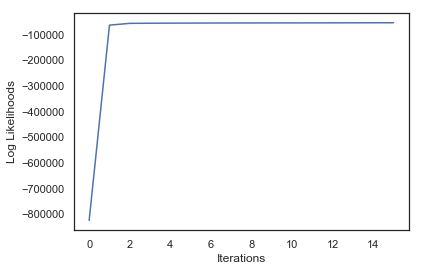

In [256]:
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihoods')
plt.show()

Now, to check my work, I'm going to take the two mean vectors, transform them into images, and print them. They should look like a 6 and a 2.

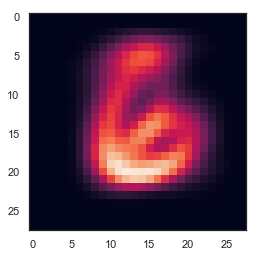

In [257]:
pic = mus[0]
new_pic = np.reshape(pic, [28,28], order='F')
plt.imshow(new_pic)
plt.show()

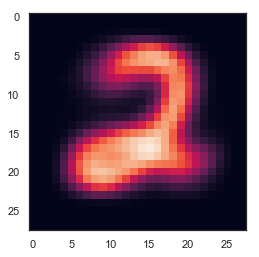

In [258]:
pic = mus[1]
new_pic = np.reshape(pic, [28,28], order='F')
plt.imshow(new_pic)
plt.show()